The purpose of this notebook is to explore the idea for a data preprocessing step that will automatically find useful split points for numerical data, and help the user apply them to make it easier for using numerical data in neural networks.  Ideally, this can close the gap between tree-based methods and NNs.  And hopefully, this could be extended to handling categorical data as well.

In [139]:
import numpy as np
import pandas as pd
import torch as th
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import datasets, tree
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [584]:
def plot_roc(y, y_hats, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for y_hat, label in zip(y_hats, labels):
        auc = roc_auc_score(y, y_hat)
        fpr, tpr, thresh = roc_curve(y, y_hat)
        ax.plot(fpr, tpr, label=f'{label}; AUC={auc:.3f}', marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
def get_path_description(dts, X_train, sample_id):
    X_test = X_train[:,0].numpy().reshape(-1,1)
    clf = dts[0]
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

In [14]:
# X, y = datasets.load_breast_cancer(return_X_y=True)

In [140]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income',
]

df_adult = pd.read_csv('data/adult.data', header=None, names=columns)
df_adult_test = pd.read_csv('data/adult.test', header=None, names=columns, skiprows=1)

df_adult['label'] = (df_adult['income']==' >50K')*1
df_adult_test['label'] = (df_adult_test['income']==' >50K.')*1
df_adult.head()

numeric = df_adult.dtypes[df_adult.dtypes=='int64'].index.tolist()
target = 'label'
numeric.remove(target)
categorical = [c for c in df_adult.columns if c not in numeric + [target, 'income']]

X = df_adult[numeric].values
y = df_adult[target].values

In [141]:
X = th.tensor(X).float()
y = th.tensor(y)

In [142]:
X.shape, y.shape

(torch.Size([32561, 6]), torch.Size([32561]))

In [143]:
X.min(dim=0)[0], X.max(dim=0)[0]

(tensor([1.7000e+01, 1.2285e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 tensor([9.0000e+01, 1.4847e+06, 1.6000e+01, 9.9999e+04, 4.3560e+03, 9.9000e+01]))

In [144]:
N_train = int(X.shape[0]*0.8)
X_train = X[:N_train,:]
y_train = y[:N_train].float()
X_test = X[N_train:,:]
y_test = y[N_train:].float()

## TODO:
- compare to numerical bucketing like `(max - min)/ N`
- how to generalize to node types without labels?
- How do standard scaling methods compare?
- Does it meet RF performance?

## Random Forest baseline

In [336]:
from sklearn.ensemble import RandomForestClassifier

In [590]:
# clf_rf = RandomForestClassifier(max_leaf_nodes=10, n_estimators=10)
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=8)

In [591]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=300)

In [592]:
y_hat_rf = clf_rf.predict_proba(X_test)[:,1]

## Neural networks

In [ ]:
N_epochs = 500

### Raw features

In [259]:
model_raw = nn.Linear(X.shape[1], 1)

In [260]:
opt = optim.Adam(model_raw.parameters(), lr=0.01)
train_losses = list()
test_losses = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_raw(X_train.float())
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses.append(loss.item())
    with th.no_grad():
        test_losses.append(
            F.binary_cross_entropy_with_logits(model_raw(X_test.float()).flatten(), y_test).item()
        )
    opt.step()

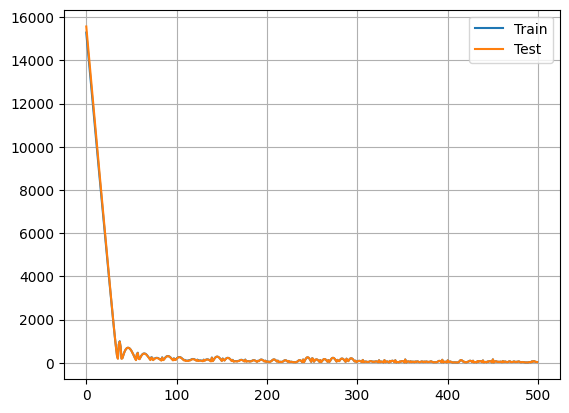

In [261]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.grid()
ax.legend()

In [262]:
y_hat_raw = model_raw(X_test.float()).flatten().detach().numpy()

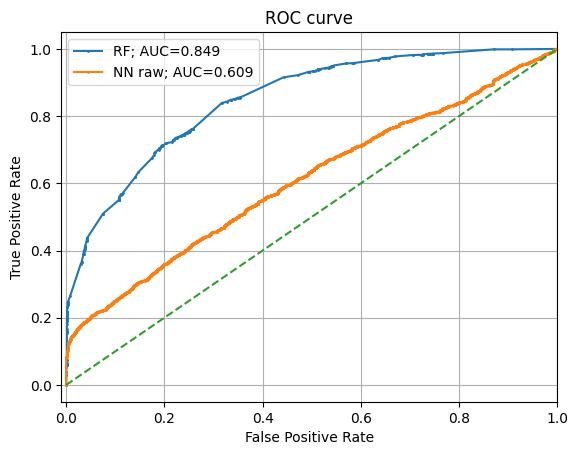

In [342]:
plot_roc(y_test,[y_hat_rf, y_hat_raw], ['RF', 'NN raw'])

### Standard scaling methods

In [264]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

#### all StandardScalar

In [265]:
ss = StandardScaler()
X_train_ss = th.tensor(ss.fit_transform(X_train))
X_test_ss = th.tensor(ss.transform(X_test))

In [266]:
model_ss = nn.Linear(X.shape[1], 1)

In [267]:
opt = optim.Adam(model_ss.parameters(), lr=0.01)
train_losses_ss = list()
test_losses_ss = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_ss(X_train_ss.float())
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses_ss.append(loss.item())
    with th.no_grad():
        test_losses_ss.append(
            F.binary_cross_entropy_with_logits(model_ss(X_test_ss.float()).flatten(), y_test).item()
        )
    opt.step()

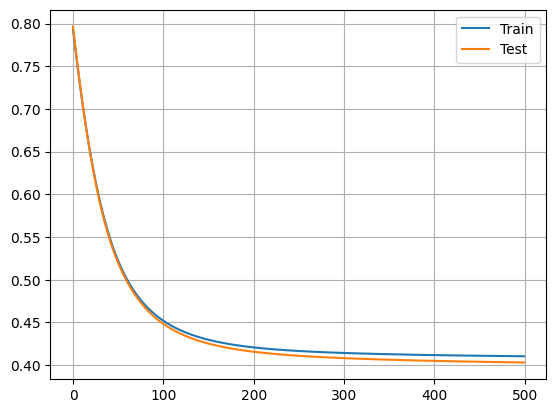

In [268]:
fig, ax = plt.subplots()
ax.plot(train_losses_ss, label='Train')
ax.plot(test_losses_ss, label='Test')
ax.grid()
ax.legend()

In [269]:
y_hat_ss = model_ss(X_test_ss.float()).flatten().detach().numpy()

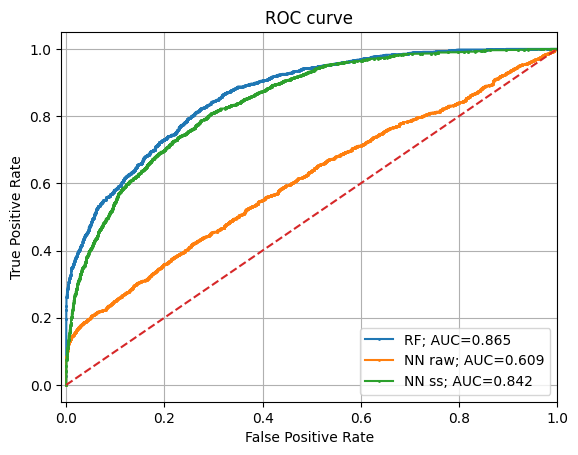

In [595]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss], ['RF', 'NN raw', 'NN ss'])

#### all QuantileTransformer

In [271]:
qt = QuantileTransformer(output_distribution='normal')
X_train_qt = th.tensor(qt.fit_transform(X_train))
X_test_qt = th.tensor(qt.transform(X_test))

In [272]:
model_qt = nn.Linear(X.shape[1], 1)

In [273]:
opt = optim.Adam(model_qt.parameters(), lr=0.01)
train_losses_qt = list()
test_losses_qt = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_qt(X_train_qt.float())
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses_qt.append(loss.item())
    with th.no_grad():
        test_losses_qt.append(
            F.binary_cross_entropy_with_logits(model_qt(X_test_qt.float()).flatten(), y_test).item()
        )
    opt.step()

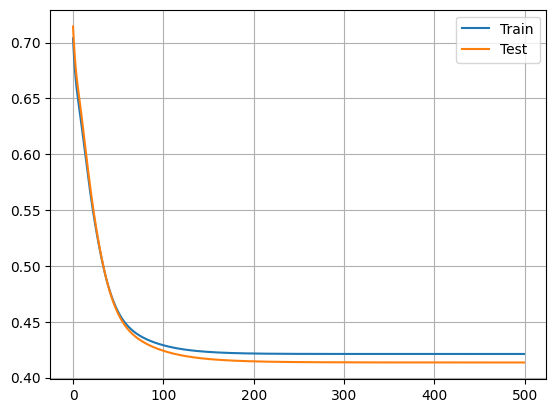

In [274]:
fig, ax = plt.subplots()
ax.plot(train_losses_qt, label='Train')
ax.plot(test_losses_qt, label='Test')
ax.grid()
ax.legend()

In [275]:
y_hat_qt = model_qt(X_test_qt.float()).flatten().detach().numpy()

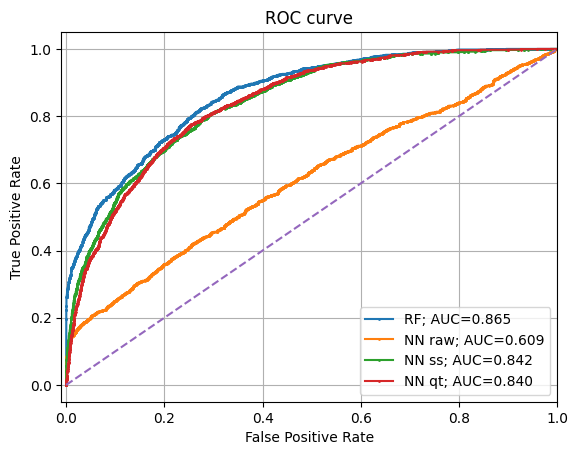

In [596]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt], ['RF', 'NN raw', 'NN ss', 'NN qt'])

#### AutoGluon logic
i.e., QuantileTransformer if skew > 0.99

In [277]:
from scipy.stats import skew

In [278]:
skew_mask = np.array([skew(X_train[:,idx])>0.99 for idx in range(X_train.shape[1])])

In [279]:
ss_2 = StandardScaler()
qt_2 = QuantileTransformer(output_distribution='normal')

X_train_ag = th.zeros_like(X_train)
X_test_ag = th.zeros_like(X_test)
X_train_ag[:,~skew_mask] = th.tensor(ss_2.fit_transform(X_train[:,~skew_mask])).float()
X_train_ag[:,skew_mask] = th.tensor(qt_2.fit_transform(X_train[:,skew_mask])).float()
X_test_ag[:,~skew_mask] = th.tensor(ss_2.transform(X_test[:,~skew_mask])).float()
X_test_ag[:,skew_mask] = th.tensor(qt_2.transform(X_test[:,skew_mask])).float()

In [280]:
model_ag = nn.Linear(X.shape[1], 1)

In [281]:
opt = optim.Adam(model_ag.parameters(), lr=0.01)
train_losses_ag = list()
test_losses_ag = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_ag(X_train_ag.float())
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses_ag.append(loss.item())
    with th.no_grad():
        test_losses_ag.append(
            F.binary_cross_entropy_with_logits(model_ag(X_test_ag.float()).flatten(), y_test).item()
        )
    opt.step()

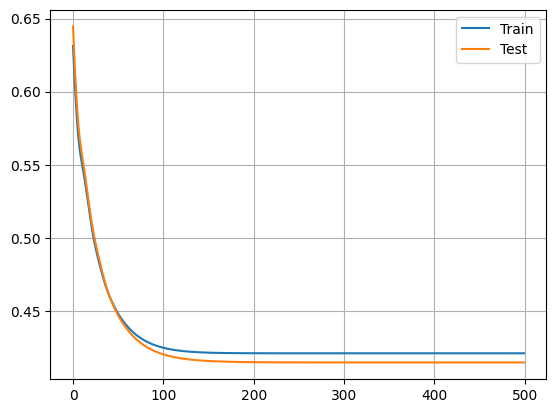

In [282]:
fig, ax = plt.subplots()
ax.plot(train_losses_ag, label='Train')
ax.plot(test_losses_ag, label='Test')
ax.grid()
ax.legend()

In [283]:
y_hat_ag = model_ag(X_test_ag.float()).flatten().detach().numpy()

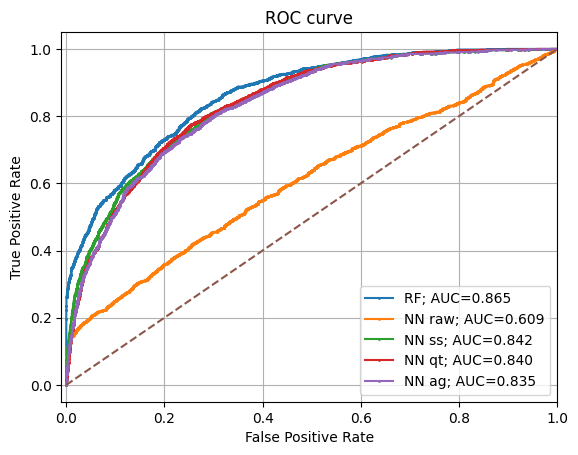

In [597]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_ag], ['RF', 'NN raw', 'NN ss', 'NN qt', 'NN ag'])

#### Bucketize
Use equally-spaced bins

In [285]:
from sklearn.preprocessing import OneHotEncoder

In [286]:
X_train_bus = list()
X_test_bus = list()
for idx in range(X_train.shape[1]):
    bins = np.linspace(X_train[:,idx].min(), X_train[:,idx].max(), 10)
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(np.digitize(X_train[:,idx], bins).reshape(-1, 1))
    X_train_bus.append(th.tensor(ohe.transform(np.digitize(X_train[:,idx], bins).reshape(-1, 1))).float())
    X_test_bus.append(th.tensor(ohe.transform(np.digitize(X_test[:,idx], bins).reshape(-1, 1))).float())
X_train_bu = th.cat(X_train_bus, dim=1)
X_test_bu = th.cat(X_test_bus, dim=1)

In [287]:
X_train.shape, X_train_bu.shape

(torch.Size([26048, 6]), torch.Size([26048, 55]))

In [288]:
model_bu = nn.Linear(X_train_bu.shape[1], 1)

In [289]:
opt = optim.Adam(model_bu.parameters(), lr=0.01)
train_losses_bu = list()
test_losses_bu = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_bu(X_train_bu.float())
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses_bu.append(loss.item())
    with th.no_grad():
        test_losses_bu.append(
            F.binary_cross_entropy_with_logits(model_bu(X_test_bu.float()).flatten(), y_test).item()
        )
    opt.step()

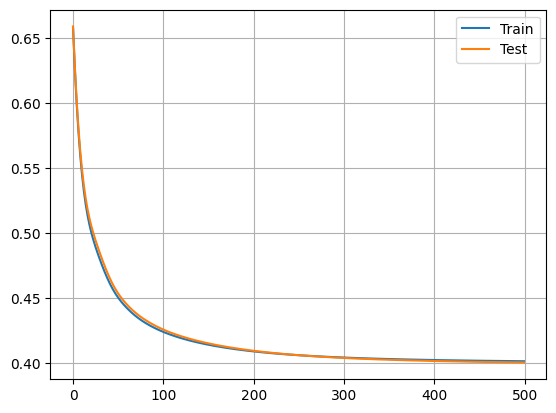

In [290]:
fig, ax = plt.subplots()
ax.plot(train_losses_bu, label='Train')
ax.plot(test_losses_bu, label='Test')
ax.grid()
ax.legend()

In [291]:
y_hat_bu = model_bu(X_test_bu.float()).flatten().detach().numpy()

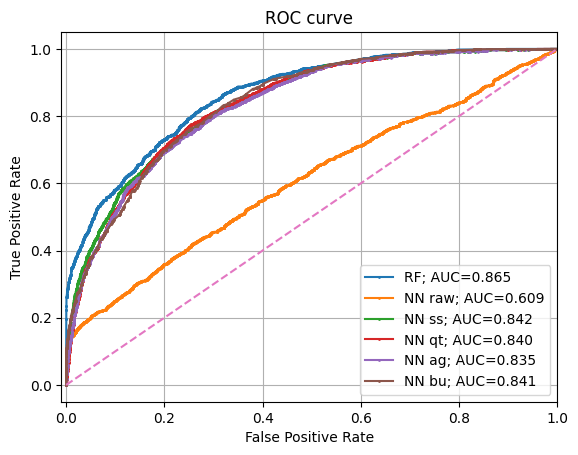

In [598]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_ag, y_hat_bu], 
    ['RF', 'NN raw', 'NN ss', 'NN qt', 'NN ag', 'NN bu']
)

## Map numeric to decision tree leafs

In [512]:
max_splits = 10
dts = list()
les = list()
X_train_dt = th.zeros_like(X_train).long()
X_test_dt = th.zeros_like(X_test).long()
for idx in range(X_train.shape[1]):
    dtc = DecisionTreeClassifier(max_leaf_nodes=max_splits)
    dtc.fit(X_train[:,idx].reshape((-1,1)), y_train)
    dts.append(dtc)
    le = LabelEncoder()
    X_train_dt[:,idx] = th.tensor(le.fit_transform(dtc.apply(X_train[:,idx].reshape((-1,1))))).long()
    X_test_dt[:,idx] = th.tensor(le.transform(dtc.apply(X_test[:,idx].reshape((-1,1))))).long()
    les.append(le)
    
assert X_train.shape==X_train_dt.shape

### Understand trees

In [545]:
# Note that these node IDs are not label encoded, as X_train_dt/X_test_dt are
get_path_description(dts, X_train, sample_id=227)

Rules used to predict sample 227:

decision node 0 : (X_test[227, 0] = 66.0) > 29.5)
decision node 2 : (X_test[227, 0] = 66.0) > 35.5)
decision node 4 : (X_test[227, 0] = 66.0) > 61.5)
decision node 6 : (X_test[227, 0] = 66.0) <= 68.5)


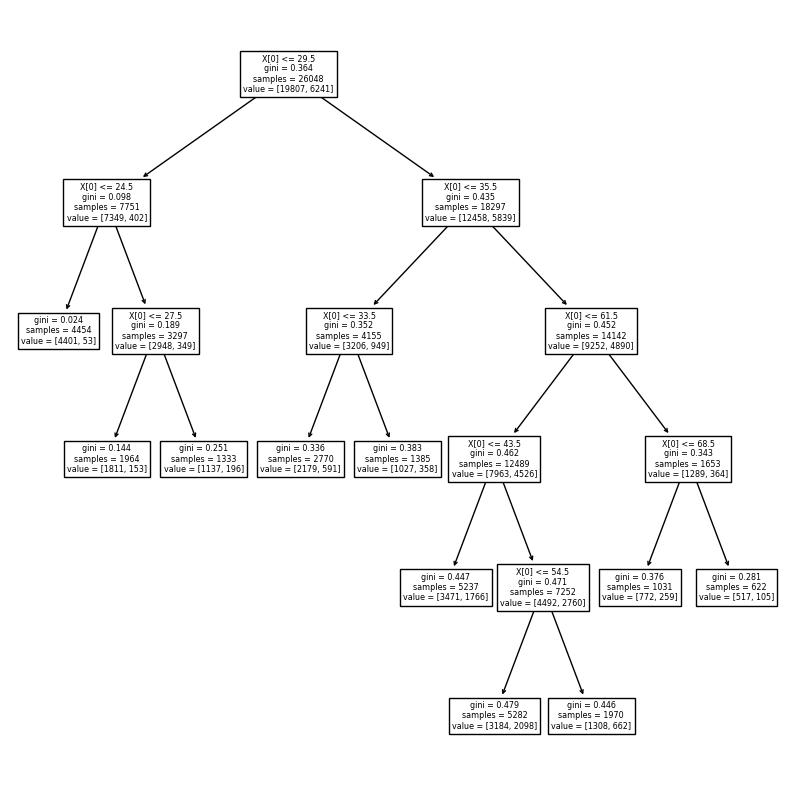

In [586]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = tree.plot_tree(dts[0], ax=ax)

### Analyze Impurity Metrics
For each feature tree, calculate the weighted average impurity observed in each leaf node, where the weight is the number of training samples in the node.  See how this relates to single-feature AUC

In [517]:
impurities = list()
impurities_mean = list()
for idx, dt in enumerate(dts):
    t = dt.tree_
    impurities.append(t.impurity[t.feature<0]*t.n_node_samples[t.feature<0])
    impurities_mean.append(impurities[-1].mean())

In [518]:
aucs = list()
for idx in range(X.shape[1]):
    auc = roc_auc_score(y_train, X_train[:,idx])
    aucs.append(max(auc, 1-auc))

In [519]:
# Features rated by their impurity reduction (best to worst)
np.argsort(impurities_mean)

array([3, 2, 0, 5, 4, 1])

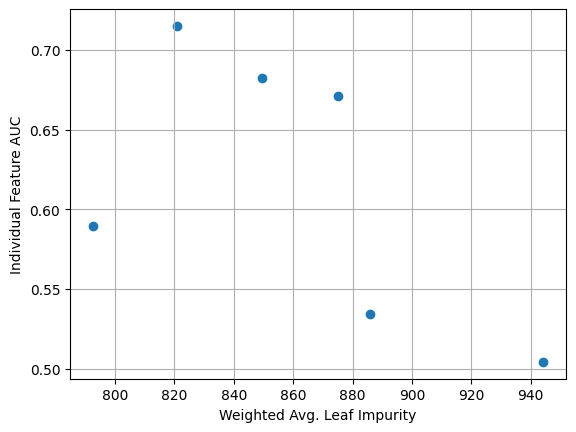

In [520]:
fig, ax = plt.subplots()
ax.scatter(impurities_mean, aucs)
ax.set(xlabel='Weighted Avg. Leaf Impurity', ylabel='Individual Feature AUC')
ax.grid()

In [521]:
# plot_roc(y_test, [-X_test[:,22]], ['feat 22'])

In [522]:
# plot_roc(y_test, [X_test[:,11]], ['feat 11'])

In [523]:
class NumericEmbedding(nn.Module):
    def __init__(self, n_uniques, h_dim, agg_type='concat'):
        super().__init__()
        
        self.embeds = nn.ModuleList()
        for n_unique in n_uniques:
            self.embeds.append(
                nn.Embedding(n_unique, h_dim)
            )
        assert agg_type in ['concat', 'sum', 'mean']
        self.agg_type = agg_type
    
    def forward(self, X):
        hs = list()
        for idx, embed in enumerate(self.embeds):
            hs.append(embed(X[:,idx]))
        
        if self.agg_type=='concat':
            return th.hstack(hs)
        elif self.agg_type=='sum':
            return th.stack(hs, dim=2).sum(dim=2).squeeze()
        elif self.agg_type=='mean':
            return th.stack(hs, dim=2).mean(dim=2).squeeze()

In [527]:
# topN = np.argsort(impurities_mean)
topN = np.arange(len(impurities_mean))
topN

array([0, 1, 2, 3, 4, 5])

In [528]:
X_t_train = X_train_dt[:, topN]
X_t_test = X_test_dt[:, topN]

In [529]:
n_uniques = (X_t_train.max(dim=0)[0]+1).numpy()

In [530]:
# model = nn.Sequential(NumericEmbedding(n_uniques, 1, 'concat'), nn.Linear(len(topN), 1))
model = nn.Sequential(NumericEmbedding(n_uniques, 1, 'concat'), nn.Linear(n_uniques.shape[0], 1))
# model = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [531]:
model[0]

NumericEmbedding(
  (embeds): ModuleList(
    (0): Embedding(10, 1)
    (1): Embedding(10, 1)
    (2): Embedding(10, 1)
    (3): Embedding(10, 1)
    (4): Embedding(10, 1)
    (5): Embedding(10, 1)
  )
)

In [532]:
opt = optim.Adam(model.parameters(), lr=0.01)
train_losses = list()
test_losses = list()
for e in range(500):
    opt.zero_grad()
    logits = model(X_t_train)
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses.append(loss.item())
    with th.no_grad():
        test_losses.append(
            F.binary_cross_entropy_with_logits(model(X_t_test).flatten(), y_test).item()
        )
    opt.step()

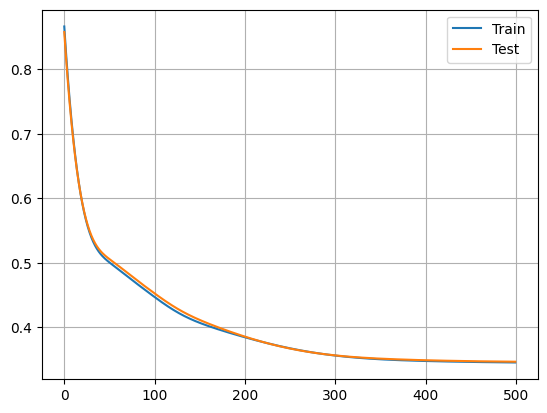

In [533]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.grid()
ax.legend()

In [534]:
y_hat_all = model(X_t_test).flatten().detach().numpy()

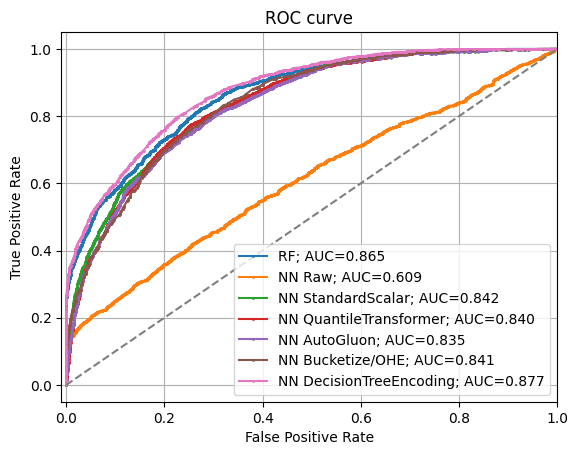

In [599]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_ag, y_hat_bu, y_hat_all],
    ['RF', 'NN Raw', 'NN StandardScalar', 'NN QuantileTransformer', 'NN AutoGluon', 'NN Bucketize/OHE', 'NN DecisionTreeEncoding'],
    # x_max=0.1,
)

#### Visualize embeddings

In [587]:
from sklearn.decomposition import PCA

In [536]:
model[0]

NumericEmbedding(
  (embeds): ModuleList(
    (0): Embedding(10, 1)
    (1): Embedding(10, 1)
    (2): Embedding(10, 1)
    (3): Embedding(10, 1)
    (4): Embedding(10, 1)
    (5): Embedding(10, 1)
  )
)

In [537]:
with th.no_grad():
    X_embed_train = model[0](X_t_train).numpy()
    X_embed_test = model[0](X_t_test).numpy()

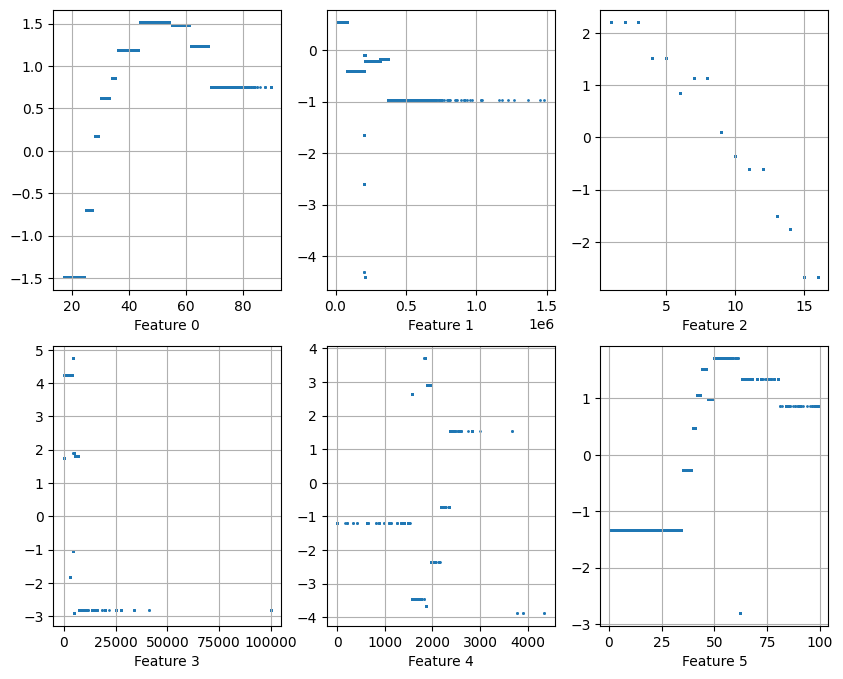

In [553]:
# Raw vs learned
fig, axs = plt.subplots(2, int(X_embed_train.shape[1]/2), figsize=(10, 8))
for idx in range(X_embed_train.shape[1]):
    ax = axs.reshape(-1)[idx]
    _ = ax.scatter(X_train[:, idx], X_embed_train[:, idx], s=1)
    ax.set(xlabel=f'Feature {idx}')
    _ = ax.grid()

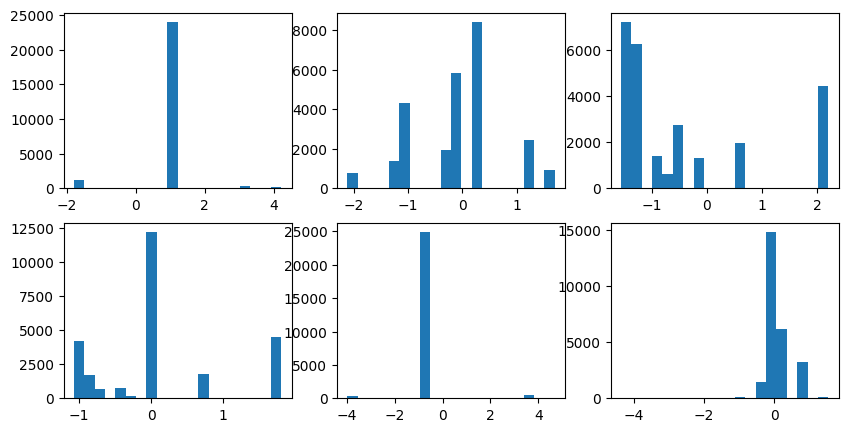

In [437]:
fig, axs = plt.subplots(2, int(X_embed_train.shape[1]/2), figsize=(10, 5))
for idx in range(X_embed_train.shape[1]):
    ax = axs.reshape(-1)[idx]
    _ = ax.hist(X_embed_train[:,idx], bins=20)

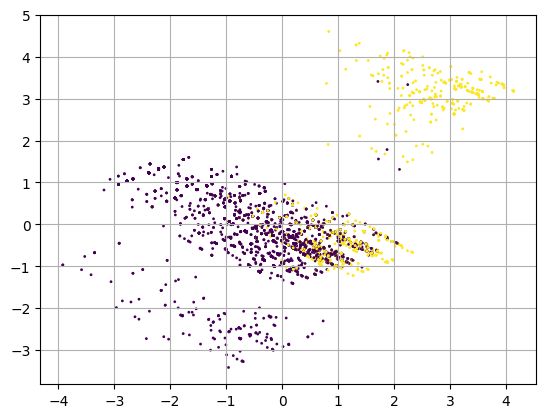

In [583]:
pca = PCA(n_components=2)
pca.fit(X_embed_train)
fig, ax = plt.subplots()
ax.scatter(pca.transform(X_embed_test)[:,0], pca.transform(X_embed_test)[:,1], c=y_test, s=1)
_ = ax.grid()

#### Sanity
Verify that using bucketing and embedding layer is same as OHE (**it does.**)

In [312]:
X_train_san = th.zeros_like(X_train).long()
X_test_san = th.zeros_like(X_test).long()
for idx in range(X_train.shape[1]):
    bins = np.linspace(X_train[:,idx].min(), X_train[:,idx].max(), 10)
    X_train_san[:,idx] = th.tensor(np.digitize(X_train[:,idx], bins)-1).long()
    X_test_san[:,idx] = th.tensor(np.digitize(X_test[:,idx], bins)-1).long()

In [313]:
model_san = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [314]:
opt = optim.Adam(model_san.parameters(), lr=0.01)
train_losses_san = list()
test_losses_san = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_san(X_train_san)
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses_san.append(loss.item())
    with th.no_grad():
        test_losses_san.append(
            F.binary_cross_entropy_with_logits(model_san(X_test_san).flatten(), y_test).item()
        )
    opt.step()

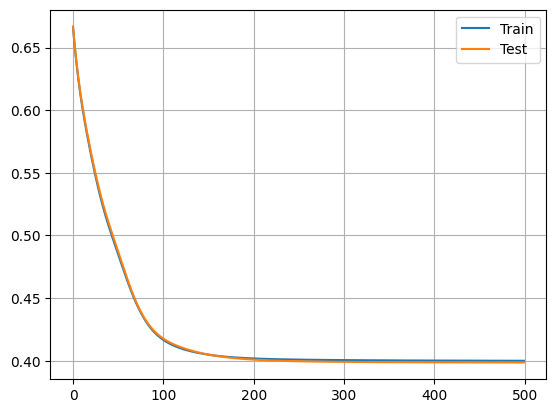

In [315]:
fig, ax = plt.subplots()
ax.plot(train_losses_san, label='Train')
ax.plot(test_losses_san, label='Test')
ax.grid()
ax.legend()

In [316]:
y_hat_san = model_san(X_test_san).flatten().detach().numpy()

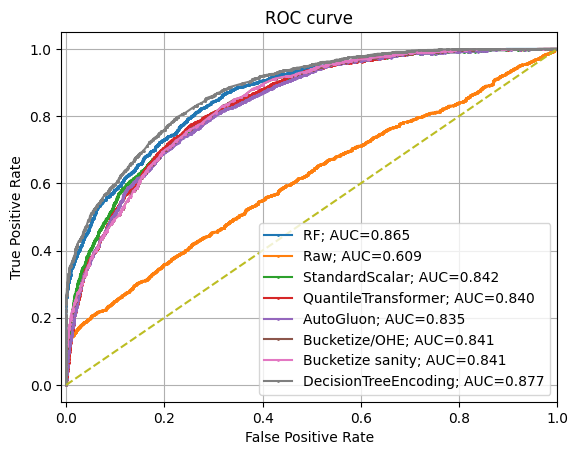

In [600]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_ag, y_hat_bu, y_hat_san, y_hat_all],
    ['RF', 'Raw', 'StandardScalar', 'QuantileTransformer', 'AutoGluon', 'Bucketize/OHE', 'Bucketize sanity', 'DecisionTreeEncoding'],
    # x_max=0.1,
)

### Top 5
Restrict to top 5 features

In [555]:
topN = np.argsort(impurities_mean)[:5]#[-5::]
topN

array([3, 2, 0, 5, 4])

In [319]:
X_t_train = X_t[:N_train, topN]
X_t_test = X_t[N_train:, topN]

In [320]:
n_uniques = (X_t_train.max(dim=0)[0]+1).numpy()

In [321]:
model_top5 = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [322]:
model_top5[0]

NumericEmbedding(
  (embeds): ModuleList(
    (0): Embedding(10, 8)
    (1): Embedding(10, 8)
    (2): Embedding(10, 8)
    (3): Embedding(10, 8)
    (4): Embedding(10, 8)
  )
)

In [323]:
opt = optim.Adam(model_top5.parameters(), lr=0.01)
train_losses = list()
test_losses = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_top5(X_t_train)
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses.append(loss.item())
    with th.no_grad():
        test_losses.append(
            F.binary_cross_entropy_with_logits(model_top5(X_t_test).flatten(), y_test).item()
        )
    opt.step()

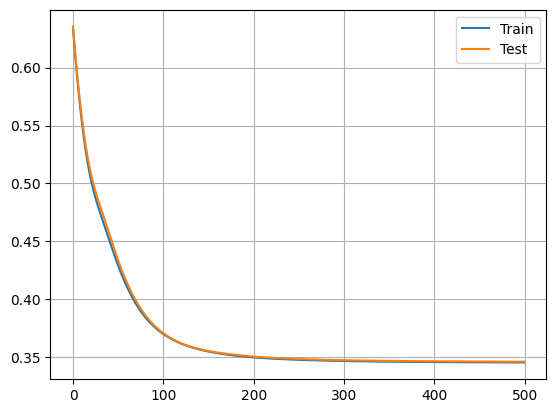

In [324]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.grid()
ax.legend()

In [325]:
y_hat_top5 = model_top5(X_t_test).flatten().detach().numpy()

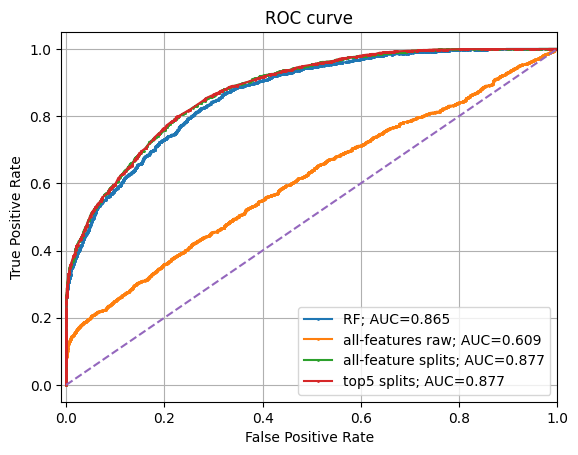

In [601]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_all, y_hat_top5],
    ['RF', 'all-features raw', 'all-feature splits', 'top5 splits'],
)

### Digging into top feature

In [556]:
idx_top = topN[0]
idx_top

3

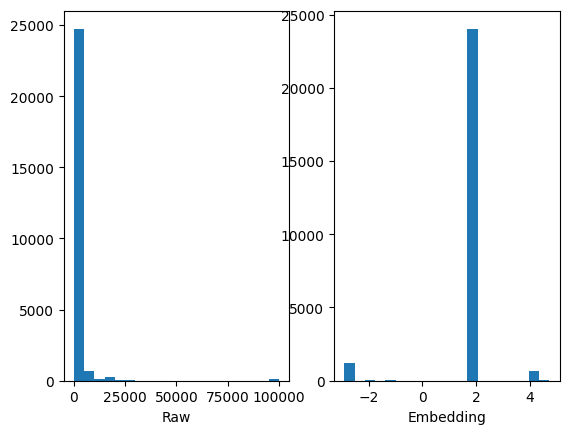

In [589]:
fig, axs = plt.subplots(1, 2)
_ = axs[0].hist(X_train[:, idx_top], bins=20)
axs[0].set(xlabel='Raw')
axs[1].hist(X_embed_train[:, idx_top], bins=20)
_ = axs[1].set(xlabel='Embedding')

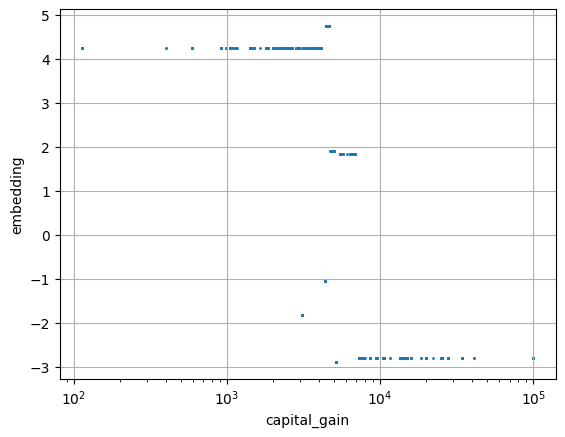

In [571]:
fig, ax = plt.subplots()
ax.scatter(X_train[:, idx_top], X_embed_train[:, idx_top], s=1)
ax.semilogx()
ax.set(xlabel=f'{numeric[idx_top]}', ylabel='embedding')
_ = ax.grid()

### Bottom 5
Restrict to bottom 5 features

In [327]:
topN = np.argsort(impurities_mean)[-5::]
topN

array([2, 0, 5, 4, 1])

In [328]:
X_t_train = X_t[:N_train, topN]
X_t_test = X_t[N_train:, topN]

In [329]:
n_uniques = (X_t_train.max(dim=0)[0]+1).numpy()

In [330]:
model_bottom5 = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [331]:
model_bottom5[0]

NumericEmbedding(
  (embeds): ModuleList(
    (0): Embedding(10, 8)
    (1): Embedding(10, 8)
    (2): Embedding(10, 8)
    (3): Embedding(10, 8)
    (4): Embedding(10, 8)
  )
)

In [332]:
opt = optim.Adam(model_bottom5.parameters(), lr=0.01)
train_losses = list()
test_losses = list()
for e in range(N_epochs):
    opt.zero_grad()
    logits = model_bottom5(X_t_train)
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses.append(loss.item())
    with th.no_grad():
        test_losses.append(
            F.binary_cross_entropy_with_logits(model_bottom5(X_t_test).flatten(), y_test).item()
        )
    opt.step()

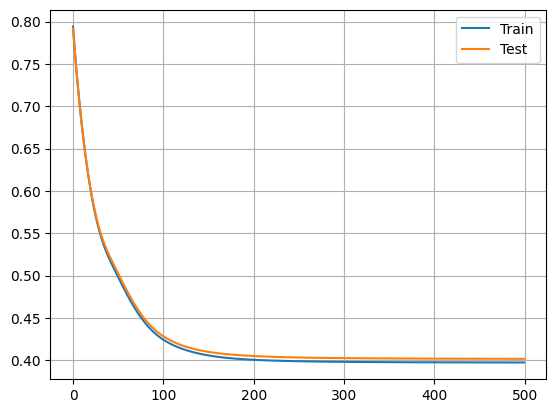

In [333]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.grid()
ax.legend()

In [334]:
y_hat_bottom5 = model_bottom5(X_t_test).flatten().detach().numpy()

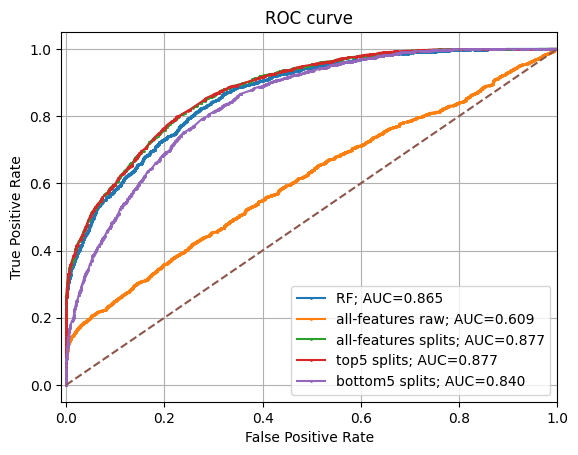

In [602]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_all, y_hat_top5, y_hat_bottom5],
    ['RF', 'all-features raw', 'all-features splits', 'top5 splits', 'bottom5 splits'],
)

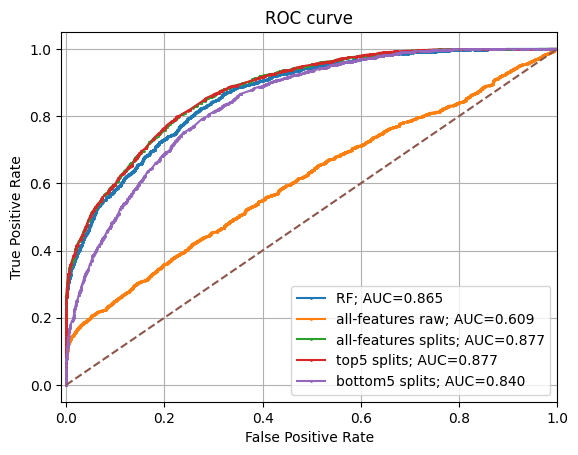

In [603]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_all, y_hat_top5, y_hat_bottom5],
    ['RF', 'all-features raw', 'all-features splits', 'top5 splits', 'bottom5 splits'],
    # x_max=0.1,
)

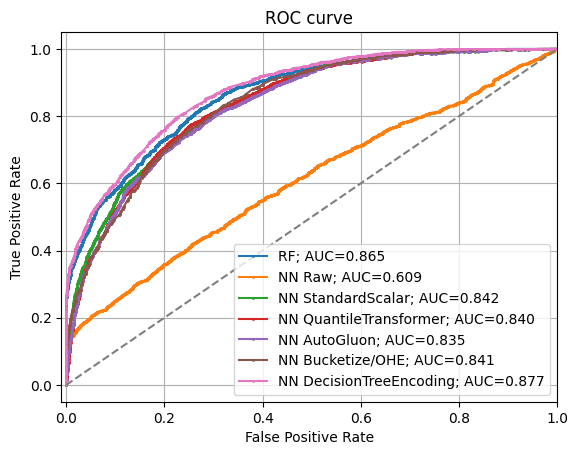

In [604]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_ag, y_hat_bu, y_hat_all],
    ['RF', 'NN Raw', 'NN StandardScalar', 'NN QuantileTransformer', 'NN AutoGluon', 'NN Bucketize/OHE', 'NN DecisionTreeEncoding'],
    # x_max=0.1,
)